In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### 3. train/valid/test split

In [2]:
%%time
import zipfile
import requests
import os
import io
from urllib.parse import urlencode

# public_key = "https://disk.yandex.ru/d/GHFPakrPFt1JVQ"
public_key = "https://disk.yandex.ru/d/p-yNGHbQ0mi7EQ"
folder_name = "Архив"
asset_zip_path = os.path.join(os.getcwd(), f"{folder_name}.zip")

def download_and_unzip(load_from):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

  # Получаем загрузочную ссылку
  final_url = base_url + urlencode(dict(public_key=load_from))
  try:
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    print('Success! The data has been loaded')
  except:
    "Could not load the content of the URL"

  print("Unpacking the data...")
  try:
    extract_to = os.getcwd()

    z = zipfile.ZipFile(io.BytesIO(download_response.content))
    z.extractall(extract_to)
    print(f'Done! The data is available here {extract_to}')
  except:
    "Error occured while extracting the data"

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(public_key)

Success! The data has been loaded
Unpacking the data...
Done! The data is available here /content
CPU times: user 3.61 s, sys: 1.43 s, total: 5.04 s
Wall time: 20.8 s


In [3]:
df_1min = load_pkl('experiments/model_one_fc/data/data_shift_time_1min.pkl')
df_5min = load_pkl('experiments/model_one_fc/data/data_shift_time_5min.pkl')
df_1hour = load_pkl('experiments/model_one_fc/data/data_shift_time_1hour.pkl')
df_1day = load_pkl('experiments/model_one_fc/data/data_shift_time_1day.pkl')


In [4]:
df_1min.head()

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time
0,2022-10-03 10:01:00,219.00,219.93,87793.0,218.00,220.25,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00
1,2022-10-03 10:02:00,219.80,220.80,61549.0,219.70,220.55,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00
2,2022-10-03 10:03:00,220.24,219.34,52640.0,219.20,220.38,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00
3,2022-10-03 10:04:00,219.17,218.96,61506.0,217.70,219.40,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00
4,2022-10-03 10:05:00,218.82,218.30,51464.0,217.76,218.96,GAZP,0,0.0,0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00


In [5]:
df_5min.head()

,time,open_5min,close_5min,volume_5min,low_5min,high_5min,ticker
0,2022-10-03 10:05:00,219.00,218.30,314952.0,217.70,220.55,GAZP
1,2022-10-03 10:10:00,218.30,218.50,182525.0,216.19,218.78,GAZP
2,2022-10-03 10:15:00,218.11,215.86,193758.0,215.31,218.13,GAZP
3,2022-10-03 10:20:00,215.83,216.85,91747.0,215.70,217.39,GAZP
4,2022-10-03 10:25:00,216.85,216.58,52824.0,216.40,217.16,GAZP


In [6]:
df_1hour.head()

,time,open_1hour,close_1hour,volume_1hour,low_1hour,high_1hour,ticker
0,2022-10-03 11:00:00,219.00,215.80,1623411.0,213.63,220.55,GAZP
1,2022-10-03 12:00:00,215.80,216.36,411786.0,214.96,216.78,GAZP
2,2022-10-03 13:00:00,216.34,215.88,237084.0,215.43,216.43,GAZP
3,2022-10-03 14:00:00,215.85,217.10,573509.0,215.53,217.77,GAZP
4,2022-10-03 15:00:00,217.12,216.94,364609.0,216.50,217.49,GAZP


In [7]:
df_1day.head()

,time,open_1day,close_1day,volume_1day,low_1day,high_1day,ticker
0,2022-09-30 23:50:00,231.68,217.70,24588842.0,189.42,238.72,GAZP
1,2022-10-03 23:50:00,219.00,215.83,5070201.0,213.63,220.55,GAZP
2,2022-10-04 23:50:00,216.48,210.72,4975859.0,208.80,216.70,GAZP
3,2022-10-05 23:50:00,211.50,209.50,5322122.0,202.85,211.50,GAZP
4,2022-10-06 23:50:00,210.00,212.86,5165564.0,209.60,216.88,GAZP


In [8]:
df_1min['target'] = (df_1min['result'] == 'WIN').astype(int)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_82547/261364035.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()


<Axes: xlabel='time'>

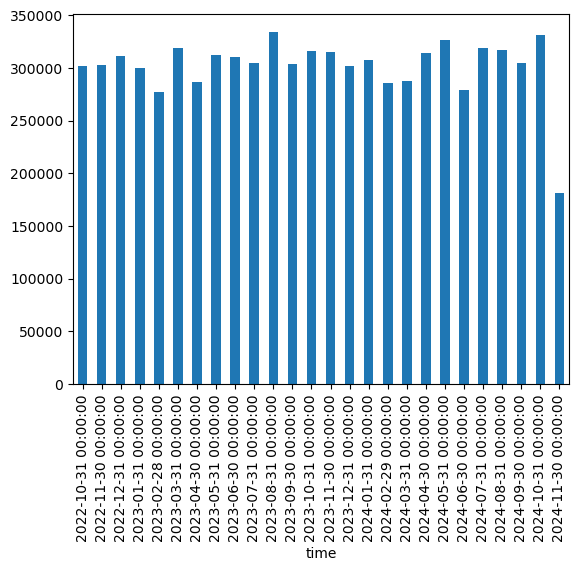

In [9]:
df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_82547/2492958762.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.mean().plot.bar()


<Axes: xlabel='time'>

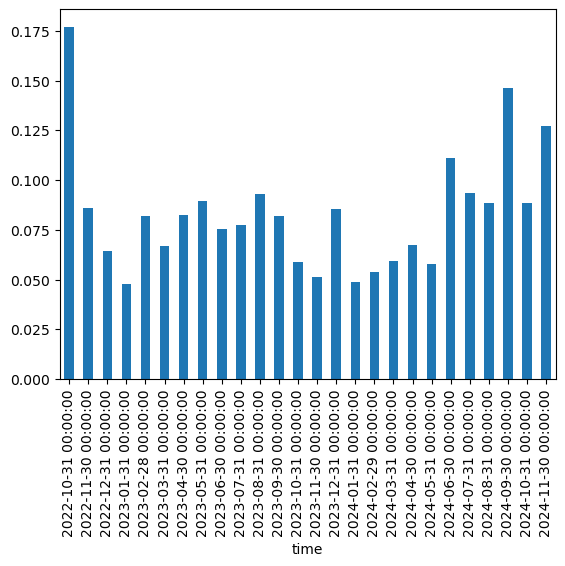

In [10]:
df_1min[['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.mean().plot.bar()

In [11]:
#в 2024 году - 248 рабочих дней, возьмем длину последовательности данных 200 (и так будет долго учиться)

![](imoex.png)

In [12]:
mask_train = np.array((pd.Timestamp('2023-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-11-19')))

In [13]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(2453935, 597323, 620944, 497823)

In [14]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

4170025

In [15]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.5884700931049575,
 0.14324206689408336,
 0.14890654132768988,
 0.11938129867326934)

In [16]:
df_1min.loc[mask_train, 'target'].mean(), df_1min.loc[mask_valid, 'target'].mean(), df_1min.loc[mask_test, 'target'].mean(), df_1min.loc[mask_test2, 'target'].mean()

(0.06044455130229611,
 0.10156816328853903,
 0.11664175835502075,
 0.10381199743684)

In [17]:
#проверки

In [18]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

True

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_82547/988860516.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_1min.loc[mask_data, ['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()


<Axes: xlabel='time'>

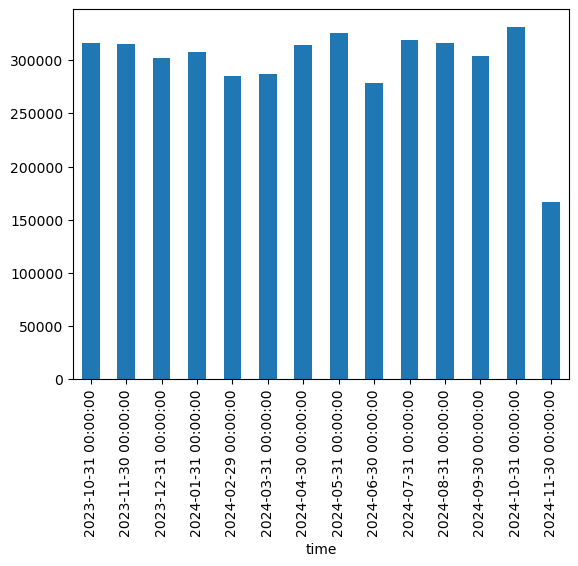

In [19]:
df_1min.loc[mask_data, ['time', 'target']].groupby(pd.Grouper(key='time', freq='M')).target.count().plot.bar()

In [20]:
#indexes

inds_train = df_1min.index[mask_train].values
inds_valid = df_1min.index[mask_valid].values
inds_test = df_1min.index[mask_test].values
inds_test2 = df_1min.index[mask_test2].values

In [21]:
inds_train

array([ 208476,  208477,  208478, ..., 7752162, 7752163, 7752164])

In [22]:
#проверим, что все индексы валидны
#у каждой точки должно быть 200 точек назад (минут, 5минут, часов, дней)

In [23]:
df_1min.head()

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time,target
0,2022-10-03 10:01:00,219.00,219.93,87793.0,218.00,220.25,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00,0
1,2022-10-03 10:02:00,219.80,220.80,61549.0,219.70,220.55,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00,0
2,2022-10-03 10:03:00,220.24,219.34,52640.0,219.20,220.38,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00,0
3,2022-10-03 10:04:00,219.17,218.96,61506.0,217.70,219.40,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00,0
4,2022-10-03 10:05:00,218.82,218.30,51464.0,217.76,218.96,GAZP,0,0.0,0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00,0


In [24]:
def check_valid_inds(inds, df_1min, len_seq=200):
    ind_1min_start = df_1min.loc[inds, 'index_1min_start'].values.astype(int)
    ind_1min_end = inds.astype(int)
    assert (~np.isnan(ind_1min_start)).all() & (~np.isnan(ind_1min_end)).all() &\
                                               ((ind_1min_end - ind_1min_start + 1) >= len_seq).all(), 'Error: 1min'

    ind_5min_start = df_1min.loc[inds, 'index_start_5min'].values.astype(int)
    ind_5min_end = df_1min.loc[inds, 'index_5min'].values.astype(int)
    assert (~np.isnan(ind_5min_start)).all() & (~np.isnan(ind_5min_end)).all() &\
                                                ((ind_5min_end - ind_5min_start + 1) >= len_seq).all(), 'Error: 5min'

    ind_1hour_start = df_1min.loc[inds, 'index_start_1hour'].values.astype(int)
    ind_1hour_end = df_1min.loc[inds, 'index_1hour'].values.astype(int)
    assert (~np.isnan(ind_1hour_start)).all() & (~np.isnan(ind_1hour_end)).all() &\
                                                ((ind_1hour_end - ind_1hour_start + 1) >= len_seq).all(), 'Error: 1hour'

    ind_1day_start = df_1min.loc[inds, 'index_start_1day'].values.astype(int)
    ind_1day_end = df_1min.loc[inds, 'index_1day'].values.astype(int)
    assert (~np.isnan(ind_1day_start)).all() & (~np.isnan(ind_1day_end)).all() &\
                                                ((ind_1day_end - ind_1day_start + 1) >= len_seq).all(), 'Error: 1day'

    return 'All Good'


In [25]:
check_valid_inds(inds_train, df_1min, len_seq=200)

'All Good'

In [26]:
check_valid_inds(inds_valid, df_1min, len_seq=200)

'All Good'

In [27]:
check_valid_inds(inds_test, df_1min, len_seq=200)

'All Good'

In [28]:
check_valid_inds(inds_test2, df_1min, len_seq=200)

'All Good'

### 4. Model Three

In [29]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [30]:
df_1min['ticker_code'] = df_1min['ticker'].astype('category').cat.codes

In [31]:
df_1min['ticker_code'].value_counts()

ticker_code
2     447059
11    446997
13    446747
4     444970
9     443270
15    442772
5     442355
0     442155
1     440282
12    436866
8     436514
10    432950
6     431898
7     429839
3     427247
16    422797
17    420498
14    412130
Name: count, dtype: int64

In [32]:
df_1min['ticker_code'].max()

17

In [33]:
df_1min['ticker'].value_counts()

ticker
GAZP    447059
ROSN    446997
SBER    446747
LKOH    444970
NVTK    443270
TATN    442772
MAGN    442355
ALRS    442155
CHMF    440282
RUAL    436866
NLMK    436514
OZON    432950
MGNT    431898
MTSS    429839
GMKN    427247
TCSG    422797
YDEX    420498
SNGS    412130
Name: count, dtype: int64

In [34]:
dict(enumerate(df_1min['ticker'].astype('category').cat.categories))

{0: 'ALRS',
 1: 'CHMF',
 2: 'GAZP',
 3: 'GMKN',
 4: 'LKOH',
 5: 'MAGN',
 6: 'MGNT',
 7: 'MTSS',
 8: 'NLMK',
 9: 'NVTK',
 10: 'OZON',
 11: 'ROSN',
 12: 'RUAL',
 13: 'SBER',
 14: 'SNGS',
 15: 'TATN',
 16: 'TCSG',
 17: 'YDEX'}

#### 4.1 PyDataset

In [35]:
class CandleData:
    def __init__(self, df_1min, df_5min, df_1hour, df_1day):
        self.df_1min = df_1min
        self.df_5min = df_5min
        self.df_1hour = df_1hour
        self.df_1day = df_1day
        self.make_np_arr_data()

    def make_np_arr_data(self):
        #time
        time_cyclic = (self.df_1min['time'] - pd.to_datetime(self.df_1min['time'].dt.date) - pd.Timedelta('10:01:00')) / pd.Timedelta('13:49:00')
        self.df_1min['sin_time'] = np.sin(time_cyclic * 2 * np.pi)
        self.df_1min['cos_time'] = np.cos(time_cyclic * 2 * np.pi)

        day_of_week_cyclic = np.minimum(self.df_1min['time'].dt.dayofweek, 4) / 4
        self.df_1min['sin_day'] = np.sin(day_of_week_cyclic * 2 * np.pi)
        self.df_1min['cos_day'] = np.cos(day_of_week_cyclic * 2 * np.pi)

        #1min
        cols_arr_1min = ['sin_time', 'cos_time', 'sin_day', 'cos_day',
                         'open', 'close', 'volume', 'low', 'high']
        self.arr_1min = np.array(self.df_1min[cols_arr_1min])

        #cols index_slice
        cols_index_time_slice = ['index_1min_start',
                         'index_5min', 'index_start_5min',
                         'index_1hour', 'index_start_1hour',
                         'index_1day', 'index_start_1day']
        self.index_time_slice_1min = np.array(self.df_1min[cols_index_time_slice])

        #cols ticker
        self.ticker_code_1min = np.array(self.df_1min['ticker_code'])

        #5min
        cols_arr_5min = ['open_5min', 'close_5min', 'volume_5min', 'low_5min', 'high_5min']
        self.arr_5min = np.array(self.df_5min[cols_arr_5min])

        #1hour
        cols_arr_1hour = ['open_1hour', 'close_1hour', 'volume_1hour', 'low_1hour', 'high_1hour']
        self.arr_1hour = np.array(self.df_1hour[cols_arr_1hour])

        #1day
        cols_arr_1day = ['open_1day', 'close_1day', 'volume_1day', 'low_1day', 'high_1day']
        self.arr_1day = np.array(self.df_1day[cols_arr_1day])

        #target
        self.target_1min = df_1min['target'].values


class dataset(tf.keras.utils.PyDataset):

    def __init__(self, data, inds, count_samples=None, len_seq=200,  batch_size=32, shuffle=False, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.inds = inds
        self.len_seq = len_seq
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.count_samples = count_samples

        if self.shuffle:
            self.inds = np.random.permutation(self.inds)

    def __len__(self):
        # Return number of batches.
        if self.count_samples is None:
            return math.ceil(len(self.inds) / self.batch_size)
        else:
            return math.ceil(self.count_samples / self.batch_size)

    def __getitem__(self, idx):
        # Return x, y for batch idx.
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, len(self.inds))
        batch_inds = self.inds[low:high]


        x_batch = []
        x_batch_ticker_code = []
        y_batch = []

        for i in batch_inds:
            # cols_index_time_slice = ['index_1min_start',
            #              'index_5min', 'index_start_5min',
            #              'index_1hour', 'index_start_1hour',
            #              'index_1day', 'index_start_1day']
            #1min
            ind_high_1min = i+1
            ind_low_1min = int(ind_high_1min - self.len_seq)
            tensor_1min = self.data.arr_1min[ind_low_1min:ind_high_1min, :]

            #5min
            ind_high_5min = int(self.data.index_time_slice_1min[i, 1] + 1)
            ind_low_5min = int(ind_high_5min - self.len_seq)
            tensor_5min = self.data.arr_5min[ind_low_5min:ind_high_5min, :]

            #1hour
            ind_high_1hour = int(self.data.index_time_slice_1min[i, 3] + 1)
            ind_low_1hour = int(ind_high_1hour - self.len_seq)
            tensor_1hour = self.data.arr_1hour[ind_low_1hour:ind_high_1hour, :]

            #1day
            ind_high_1day = int(self.data.index_time_slice_1min[i, 5] + 1)
            ind_low_1day =  int(ind_high_1day - self.len_seq)
            tensor_1day = self.data.arr_1day[ind_low_1day:ind_high_1day, :]

            #target
            y = self.data.target_1min[i]

            #ticker
            ticker_code = self.data.ticker_code_1min[i]


            x = np.concatenate((tensor_1min, tensor_5min, tensor_1hour, tensor_1day), axis=1)

            x_batch += [x]
            x_batch_ticker_code += [ticker_code]
            y_batch += [y]

        return {'input_numeric':  np.array(x_batch), 'input_ticker' : np.array(x_batch_ticker_code)}, np.array(y_batch)



    def on_epoch_end(self):
        if self.shuffle:
            self.inds = np.random.permutation(self.inds)

In [36]:
data = CandleData(df_1min, df_5min, df_1hour, df_1day)


dataset_train = dataset(data, inds_train, count_samples=64*10_000, len_seq=200, batch_size=64, shuffle=True)
dataset_valid = dataset(data, inds_valid, len_seq=200, batch_size=64, shuffle=False)
dataset_test = dataset(data, inds_test, len_seq=200, batch_size=64, shuffle=False)
dataset_test2 = dataset(data, inds_test2, len_seq=200, batch_size=64, shuffle=False)

In [37]:
len(dataset_valid)

9334

In [38]:
# inds_train_subsample = np.random.permutation(inds_train)[:500_000//500]
# inds_valid_subsample = np.random.permutation(inds_valid)[:100_000//600]
# inds_test_subsample = np.random.permutation(inds_test)[:100_000//800]
# inds_test2_subsample = np.random.permutation(inds_test2)[:100_000//100]


# dataset_train_subsample = dataset(data, inds_train_subsample, len_seq=200, batch_size=64, shuffle=False)
# dataset_valid_subsample = dataset(data, inds_valid_subsample, len_seq=200, batch_size=64, shuffle=False)
# dataset_test_subsample = dataset(data, inds_test_subsample, len_seq=200, batch_size=64, shuffle=False)
# dataset_test2_subsample = dataset(data, inds_test2_subsample, len_seq=200, batch_size=64, shuffle=False)

#### 4.2 Model

In [39]:
import tensorflow as tf
from datetime import datetime
from linformer.multihead_attention import MHAttention
from linformer.util import get_EF

In [40]:
import tensorflow as tf
from linformer.util import identity, gen_causal_mask, get_EF, Residual, PositionalEmbedding, ProjectInOut, FeedForward
from linformer.multihead_attention import MHAttention


class Linformer(tf.keras.Model):
    """
    Reproducing the Linformer Paper
    https://arxiv.org/pdf/2006.04768.pdf

    (1) get attention for each word
    (2) apply add-normlization and residual network layer
    (3) apply feed forward network layer
    """
    def __init__(self, input_size, channels, dim_k, dim_ff=256, dim_d=None, dropout_ff=0.15,
                 nhead=4, depth=1, dropout=0.1, activation="gelu", parameter_sharing="layerwise",
                 k_reduce_by_layer=0, full_attention=False, include_ff=True, w_o_intermediate_dim=None, decoder_mode=False,
                 causal=False, method="learnable", ff_intermediate=None):
        super(Linformer, self).__init__()
        assert activation == "gelu" or activation == "relu", "Only gelu and relu activations supported for now"
        assert parameter_sharing == "none" or parameter_sharing == "headwise" or parameter_sharing == "kv" or parameter_sharing == "layerwise", "The `parameter_sharing` flag has to be either 'none', 'headwise', 'kv', or 'layerwise'."
        assert channels % nhead == 0 if dim_d is None else True, "If `dim_d` is not set to a custom value, `channels` must be divisible by `nhead`!"
        assert not (ff_intermediate and parameter_sharing=="layerwise"), "Parameter sharing must not be layerwise if ff_intermediate is enabled!"
        assert not (ff_intermediate and decoder_mode), "Raising the dimension in the middle cannot be done in the decoder!"

        layers = []
        self.decoder_mode = decoder_mode
        self.input_size = input_size
        self.channels = channels
        self.depth = depth
        self.nhead = nhead

        head_dim = channels // nhead if dim_d is None else dim_d

        # used for layer-wise parameter sharing
        E_proj = get_EF(input_size, dim_k, method, head_dim)

        causal_mask = gen_causal_mask(input_size, dim_k, full_attention) if causal else None
        # If we want causal but only with the encoder
        causal_enc = gen_causal_mask(input_size, dim_k, full_attention) if (causal and not decoder_mode) else None

        get_attn = lambda attn_channels, curr_dim_k: MHAttention(input_size, head_dim, attn_channels, curr_dim_k, nhead, dropout, parameter_sharing, E_proj, E_proj, full_attention, causal_enc, w_o_intermediate_dim, decoder_mode=False, method=method)
        get_attn_context = lambda attn_channels, curr_dim_k: MHAttention(input_size, head_dim, attn_channels, curr_dim_k, nhead, dropout, parameter_sharing, E_proj, E_proj, full_attention, causal_mask, w_o_intermediate_dim, decoder_mode=True, method=method)
        get_ff = lambda input_channels, output_channels: FeedForward(input_channels, output_channels, dim_ff, dropout_ff, activation)

        for index in range(depth):
            input_channels = ff_intermediate if (index != 0 and ff_intermediate is not None) and not decoder_mode else channels
            output_channels = ff_intermediate if (index != depth-1 and ff_intermediate is not None) and not decoder_mode else channels
            # TODO: Change the input and output channels here
            attn_layer = get_attn(input_channels, max(1, dim_k - index*k_reduce_by_layer))
            ff_layer = get_ff(input_channels, output_channels)

            attn_layer, ff_layer = map(lambda res_ch_in, res_ch_out, fn: Residual(fn, res_ch_in, res_ch_out), (input_channels, input_channels), (input_channels, output_channels), (attn_layer, ff_layer))

            if include_ff:
                layers.append(attn_layer)
                layers.append(ff_layer)
            else:
                layers.append(attn_layer)

            if not self.decoder_mode:
                continue

            attn_context = get_attn_context(channels, max(1, dim_k - index*k_reduce_by_layer))
            ff_context = get_ff(channels, channels)

            attn_context, ff_context = map(lambda fn: Residual(fn, channels, channels), (attn_context, ff_context))

            if include_ff:
                layers.append(attn_context)
                layers.append(ff_context)
            else:
                layers.append(attn_context)

        self.seq = layers

    def call(self, tensor, **kwargs):
        """
        Input is (batch_size, seq_len, channels)
        """
        _, n, c = tensor.shape # [batch_size, window_size, channel_size]
        assert n == self.input_size, "This tensor is of the wrong size. Dimension 1 has to match the `input_size` flag"
        assert c == self.channels, "This tensor is of the wrong size. Dimension 2 has to match the `channels` flag"
        assert "embeddings" not in kwargs or self.decoder_mode, "If decoding, needs to be initialized with `decoder_mode=True`"

        for layer in self.seq:
            tensor = layer(tensor, **kwargs)
        return tensor


class LinformerLM(tf.keras.Model):
    """
    A wrapper function to accept LM tasks, inspired by https://github.com/lucidrains/sinkhorn-transformer
    Five layer as this transformer:
    (1) embed each word in the input batch of sentences
    (2) apply positional embedding to embedding word vector
    (3) dropout layer
    (4) linear transformer layer
    (5) return logit if in decoder; otherwise, return encode_txt
    """
    def __init__(self, num_tokens, input_size, channels,
                       dim_k=64, dim_ff=1024, dim_d=None,
                       dropout_ff=0.1, dropout_tokens=0.1, nhead=4, depth=2, ff_intermediate=None,
                       dropout=0.05, activation="gelu",
                       parameter_sharing="layerwise", k_reduce_by_layer=0, full_attention=False,
                       include_ff=True, w_o_intermediate_dim=None, emb_dim=None,
                       return_emb=False, decoder_mode=False, causal=False, method="learnable"):
        super(LinformerLM, self).__init__()
        emb_dim = channels if emb_dim is None else emb_dim

        self.input_size = input_size

        #self.to_token_emb = tf.keras.layers.Embedding(num_tokens, emb_dim)
        self.pos_emb = PositionalEmbedding(emb_dim)
        self.dropout_tokens = tf.keras.layers.Dropout(dropout_tokens)
        self.linformer = Linformer(input_size, channels, dim_k=dim_k,
                                   dim_ff=dim_ff, dim_d=dim_d, dropout_ff=dropout_ff,
                                   nhead=nhead, depth=depth, dropout=dropout, ff_intermediate=ff_intermediate,
                                   activation=activation, parameter_sharing=parameter_sharing,
                                   k_reduce_by_layer=k_reduce_by_layer, full_attention=full_attention, include_ff=include_ff,
                                   w_o_intermediate_dim=w_o_intermediate_dim, decoder_mode=decoder_mode, causal=causal, method=method)

        if emb_dim != channels:
            self.linformer = ProjectInOut(self.linformer, emb_dim, channels)

        self.to_logits = identity if return_emb else tf.keras.layers.Dense(num_tokens, activation='softmax')

    def call(self, tensor, **kwargs):
        """
        Input is (batch_size, seq_len), and all items are ints from [0, num_tokens-1]
        """
        #tensor = self.to_token_emb(tensor)
        tensor = self.pos_emb(tensor) + tensor
        tensor = self.dropout_tokens(tensor)
        tensor = self.linformer(tensor, **kwargs)
        tensor = self.to_logits(tensor)
        return tensor


class LinformerEnc(tf.keras.Model):
    """
    A complete seq -> seq translation task. Complete with an encoder and a decoder module.
    Top Level of encoder & decder seq2seq model
    """
    def __init__(self, enc_num_tokens, enc_input_size, enc_channels,# dec_num_tokens, dec_input_size, dec_channels,
                       enc_dim_k=64, enc_dim_ff=1024, enc_dim_d=None, enc_ff_intermediate=None,# dec_ff_intermediate=None,
                       enc_dropout_ff=0.1, enc_nhead=4, enc_depth=2, enc_dropout=0.05, enc_parameter_sharing="layerwise", enc_k_reduce_by_layer=0,
                       enc_full_attention=False, enc_include_ff=True, enc_w_o_intermediate_dim=None, enc_emb_dim=None, enc_method="learnable",
                       # dec_dim_k=64, dec_dim_ff=1024, dec_dim_d=None, dec_dropout_ff=0.1, dec_nhead=4, dec_depth=2, dec_dropout=0.05,
                       # dec_parameter_sharing="layerwise", dec_k_reduce_by_layer=0, dec_full_attention=False, dec_include_ff=True,
                       # dec_w_o_intermediate_dim=None, dec_emb_dim=None, dec_method="learnable",
                 activation="gelu", **kwargs
                ):

        super(LinformerEnc, self).__init__(**kwargs)

        self.enc_num_tokens = enc_num_tokens
        self.enc_input_size = enc_input_size
        self.enc_channels = enc_channels
        self.enc_full_attention = enc_full_attention
        self.enc_dim_k = enc_dim_k
        self.enc_dim_d = enc_dim_d
        self.enc_dim_ff = enc_dim_ff
        self.enc_nhead = enc_nhead
        self.enc_depth = enc_depth
        self.enc_dropout_ff = enc_dropout_ff
        self.enc_dropout = enc_dropout
        self.enc_parameter_sharing = enc_parameter_sharing
        self.activation = activation





        # optimizer and batch size
        # self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.encoder = LinformerLM(num_tokens=enc_num_tokens, input_size=enc_input_size, channels=enc_channels, dim_d=enc_dim_d, dim_ff=enc_dim_ff,
                                   dim_k=enc_dim_k, dropout_ff=enc_dropout_ff, nhead=enc_nhead, depth=enc_depth, dropout=enc_dropout,
                                   parameter_sharing=enc_parameter_sharing, k_reduce_by_layer=enc_k_reduce_by_layer, ff_intermediate=enc_ff_intermediate,
                                   full_attention=enc_full_attention, include_ff=enc_include_ff, w_o_intermediate_dim=enc_w_o_intermediate_dim,
                                   emb_dim=enc_emb_dim, return_emb=True, activation=activation, method=enc_method)
        # self.decoder = LinformerLM(num_tokens=dec_num_tokens, input_size=dec_input_size, channels=dec_channels, dim_d=dec_dim_d, dim_ff=dec_dim_ff,
        #                            dim_k=dec_dim_k, dropout_ff=dec_dropout_ff, nhead=dec_nhead, depth=dec_depth, dropout=dec_dropout, ff_intermediate=dec_ff_intermediate,
        #                            parameter_sharing=dec_parameter_sharing, k_reduce_by_layer=dec_k_reduce_by_layer, method=dec_method,
        #                            full_attention=dec_full_attention, include_ff=dec_include_ff, w_o_intermediate_dim=dec_w_o_intermediate_dim,
        #                            emb_dim=dec_emb_dim, decoder_mode=True, causal=True, activation=activation)

    def call(self, x, **kwargs):
        """
        Input is (batch_size, input_size), and all items are ints from [0, num_tokens-1]
        """
        return self.encoder(x, **kwargs)

    #save and load part
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
            "enc_num_tokens" : self.enc_num_tokens,
            "enc_input_size" : self.enc_input_size,
            "enc_channels" : self.enc_channels ,
            "enc_full_attention" : self.enc_full_attention ,
            "enc_dim_k" : self.enc_dim_k ,
            "enc_dim_d" : self.enc_dim_d ,
            "enc_dim_ff" : self.enc_dim_ff ,
            "enc_nhead" : self.enc_nhead ,
            "enc_depth" : self.enc_depth ,
            "enc_dropout_ff" : self.enc_dropout_ff ,
            "enc_dropout" : self.enc_dropout,
            "enc_parameter_sharing" : self.enc_parameter_sharing ,
            "activation" : self.activation
            }
        )
        return config

    @classmethod
    def from_config(cls,config):
        return cls(**config)


In [41]:
#DIM_K = 8 - 35 min (67k param)
#layerwise DIM_K = 38 -  min (67k param)
#headwise DIM_K = 35 -  min (67k param)

#DIM_K = 32 - 50 min (72k param)
#DIM_K = 64 - 1.10 min (75k param)
#DIM_K = 200 - 2.50 min (105k param)

#attention=True DIM_K = 32 - 1.20min (65 param)

#### 4.3 WarmUpCosineDecay

In [42]:
from tensorflow import keras

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    #learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))
    learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * tf.cast((global_step - warmup_steps - hold), tf.float32) / tf.cast(total_steps - warmup_steps - hold, tf.float32)))


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)

    return learning_rate


class WarmUpCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )
    def get_config(self):
        config = {
          'start_lr': self.start_lr,
          'target_lr': self.target_lr,
          'warmup_steps': self.warmup_steps,
          'total_steps': self.total_steps,
          'hold': self.hold
        }
        return config



#### 4.4 Callbacks

In [43]:
# метрики на конец эпохи

In [44]:
def get_y_true(data):
    return data.data.target_1min[data.inds[:len(data)*data.batch_size]]

def precision(y_true, y_pred, threshold):
    mask = y_pred.ravel() > threshold
    return mask.sum(), y_true.ravel()[mask].mean()



class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, datasets):
        self.datasets = datasets
        self.list_auc = []
        self.list_precision = []
        # self.list_percent = []
        # self.list_count = []
        super(MetricsCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):

        list_y_true = []
        list_y_pred = []

        list_auc = []
        list_precision = []
        # list_count = []
        # list_percent = []
        for dataset in self.datasets:
            y_true = get_y_true(dataset)
            y_pred = self.model.predict(dataset)

            list_auc += [roc_auc_score(y_true, y_pred)]
            threshold = np.quantile(y_pred, q=0.99)
            mask = y_pred.ravel() > threshold
            list_precision += [y_true.ravel()[mask].mean()]


#evaluate using one threshold
        # for dataset in self.datasets:
        #     y_true = get_y_true(dataset)
        #     y_pred = self.model.predict(dataset)

        #     list_y_true += [y_true]
        #     list_y_pred += [y_pred]


        # threshold = np.quantile(list_y_pred[1], q=0.99)

        # for y_true, y_pred in zip(list_y_true, list_y_pred):
        #     list_auc += [roc_auc_score(y_true, y_pred)]

        #     mask = y_pred.ravel() > threshold
        #     list_precision += [y_true.ravel()[mask].mean()]
        #     list_count += [mask.sum()]
        #     list_percent += [mask.mean()]

        # del list_y_true, list_y_pred
        # gc.collect()



        self.list_auc += [list_auc.copy()]
        self.list_precision += [list_precision.copy()]
        # self.list_percent += [list_percent.copy()]
        # self.list_count += [list_count.copy()]


        print('AUC_ROC: ', np.round(list_auc, decimals=3).tolist())
        # print('COUNT: ', np.round(list_count, decimals=3).tolist())
        # print('PERCENT: ', np.round(list_percent, decimals=3).tolist())
        print('PRECISION: ', np.round(list_precision, decimals=3).tolist())
        print()




#### 4.5 Train

In [105]:
! mkdir models

mkdir: cannot create directory ‘models’: File exists


In [45]:
input_shape_num = (200, 24)

enc_num_tokens = None
INPUT_SIZE = 200 # 1-dimensional
CHANNELS = 24+4 # 2-dimensional



enc_nhead = 16 #кол-во multihead
DEPTH = 2 #кол-во энкодероа

enc_full_attention = False

DIM_K = 32 #main part of paper
DIM_D = 128 #размерность слоя head in multihead
DIM_FF = 256

enc_dropout_ff = 0.13
enc_dropout = 0.13

PARAMETER_SHARING = 'headwise' #"layerwise" - базовый он вроде лучше скор имеет, но мб медленнее работает
activation = 'relu' # 'gelu'


input_num = tf.keras.layers.Input(shape=input_shape_num, name='input_numeric')
num_batchnorm = tf.keras.layers.BatchNormalization(axis=-2)(input_num) #?


ticker_size = df_1min['ticker_code'].max()+1 #18
input_emb = tf.keras.layers.Input(shape=(1,), name='input_ticker')
emb = tf.keras.layers.Embedding(ticker_size, 4) (input_emb)
emb_reshaped = tf.keras.layers.Reshape(target_shape=(4,))(emb)
emb_reshaped_repeat = tf.keras.layers.RepeatVector(input_shape_num[0])(emb_reshaped)



inputs = tf.keras.layers.concatenate([num_batchnorm, emb_reshaped_repeat])
#batch_norm = tf.keras.layers.BatchNormalization()(inputs) #Вот тут еще можно поиграться с LayerNorm

linformer = LinformerEnc(
            enc_num_tokens=enc_num_tokens,        # encoder setting
            enc_input_size=INPUT_SIZE,
            enc_channels=CHANNELS,
            enc_full_attention=enc_full_attention,
            enc_dim_k=DIM_K,
            enc_dim_d=DIM_D,
            enc_dim_ff=DIM_FF,
            enc_nhead = enc_nhead,
            enc_depth=DEPTH,
            enc_dropout_ff=enc_dropout_ff,
            enc_dropout=enc_dropout,
            enc_parameter_sharing=PARAMETER_SHARING,
            activation=activation)(inputs)



x = tf.keras.layers.GlobalAveragePooling1D()(linformer) #Почему бы не развернуть и не накинуть Dense слой?
x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x) # хз насколько он здесь нужен, нужно поэксперементировать
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)


model = tf.keras.models.Model(inputs=[input_num, input_emb],\
                                       outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ticker        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 4)      │         72 │ input_ticker[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_numeric       │ (None, 200, 24)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 24)   │        800 │ input_numeric[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 200, 4)    │          0 │ reshape[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 28)   │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linformer_enc       │ (None, 200, 28)   │    514,000 │ concatenate[0][0] │
│ (LinformerEnc)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 28)        │          0 │ linformer_enc[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 28)        │         56 │ global_average_p… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 1)         │         29 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 514,957 (1.96 MB)

 Trainable params: 514,557 (1.96 MB)

 Non-trainable params: 400 (1.56 KB)

In [111]:
EPOCHS = 20

total_steps = len(dataset_train) * EPOCHS
warmup_steps = int(0.05*total_steps)
schedule = WarmUpCosineDecay(start_lr=0.0001, target_lr=0.005, warmup_steps=warmup_steps, total_steps=total_steps, hold=warmup_steps)
#may be changed to 1
optimizer=tf.keras.optimizers.Adam(learning_rate=schedule)
#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

loss = tf.keras.losses.BinaryCrossentropy()
metric_auc_roc = tf.keras.metrics.AUC(num_thresholds=1000)


model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric_auc_roc])


metrics_callback = MetricsCallback([dataset_train, dataset_valid, dataset_test, dataset_test2])
save_callback = tf.keras.callbacks.ModelCheckpoint( "./models/model_{epoch:04d}.keras", save_freq='epoch')
callbacks = [save_callback, metrics_callback]




In [107]:
# lrs = [lr_warmup_cosine_decay(step, total_steps=total_steps, warmup_steps=warmup_steps, hold=warmup_steps) for step in np.arange(total_steps)]
# plt.plot(lrs)

In [108]:
1

1

In [ ]:
model.fit(dataset_train , epochs=EPOCHS, callbacks=callbacks)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 279s 27ms/step
9334/9334 ━━━━━━━━━━━━━━━━━━━━ 260s 28ms/step
9703/9703 ━━━━━━━━━━━━━━━━━━━━ 268s 28ms/step
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 217s 28ms/step
AUC_ROC:  [0.806, 0.703, 0.721, 0.729]
PRECISION:  [0.441, 0.168, 0.314, 0.322]

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 2076s 200ms/step - auc_9: 0.7362 - loss: 0.2058
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 274s 27ms/step
9334/9334 ━━━━━━━━━━━━━━━━━━━━ 255s 27ms/step
9703/9703 ━━━━━━━━━━━━━━━━━━━━ 265s 27ms/step
7779/7779 ━━━━━━━━━━━━━━━━━━━━ 212s 27ms/step
AUC_ROC:  [0.831, 0.729, 0.746, 0.739]
PRECISION:  [0.453, 0.167, 0.278, 0.27]

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 1968s 197ms/step - auc_9: 0.7966 - loss: 0.1911
Epoch 3/20
  431/10000 ━━━━━━━━━━━━━━━━━━━━ 14:20 90ms/step - auc_9: 0.8066 - loss: 0.1913

In [ ]:
1

In [ ]:
df_auc = pd.DataFrame(metrics_callback.list_auc)
df_precision = pd.DataFrame(metrics_callback.list_precision)
# df_count = pd.DataFrame(metrics_callback.list_count)
# df_percent = pd.DataFrame(metrics_callback.list_percent)

In [ ]:
#df_count

In [ ]:
df_precision

In [ ]:
df_auc

In [ ]:
#df_percent

# 4. Evaluate

In [46]:
import keras

model = keras.saving.load_model('./best_models/model_0002.keras',
                                custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay,
                                               'LinformerEnc' : LinformerEnc})

In [56]:
#data_tmp = dataset(data, inds_test, count_samples=64*100, len_seq=200, batch_size=64, shuffle=False)

In [51]:
#y_pred_valid = model.predict(dataset_valid)
y_pred_test = model.predict(dataset_test)
#y_pred_test2 = model.predict(dataset_test2)

9702/9703 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_numeric', 'input_ticker']. Received: the structure of inputs={'input_numeric': '*', 'input_ticker': '*'}
  warnings.warn(


9703/9703 ━━━━━━━━━━━━━━━━━━━━ 774s 80ms/step


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_82547/287518563.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_test)


<Axes: ylabel='Density'>

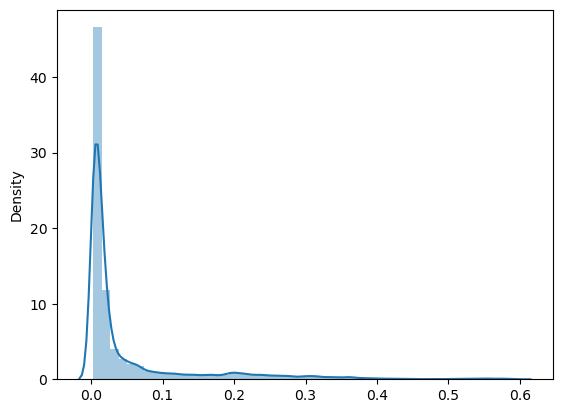

In [54]:
sns.distplot(y_pred_test)

In [57]:
df_1min.head()

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,...,index_1day,index_start_1day,result,delta_time,target,ticker_code,sin_time,cos_time,sin_day,cos_day
0,2022-10-03 10:01:00,219.00,219.93,87793.0,218.00,220.25,GAZP,0,NaN,NaN,...,NaN,NaN,LOSE,0 days 00:04:00,0,2,0.000000,1.000000,0.0,1.0
1,2022-10-03 10:02:00,219.80,220.80,61549.0,219.70,220.55,GAZP,0,NaN,NaN,...,NaN,NaN,LOSE,0 days 00:01:00,0,2,0.007579,0.999971,0.0,1.0
2,2022-10-03 10:03:00,220.24,219.34,52640.0,219.20,220.38,GAZP,0,NaN,NaN,...,NaN,NaN,LOSE,0 days 00:03:00,0,2,0.015158,0.999885,0.0,1.0
3,2022-10-03 10:04:00,219.17,218.96,61506.0,217.70,219.40,GAZP,0,NaN,NaN,...,NaN,NaN,LOSE,0 days 00:02:00,0,2,0.022736,0.999742,0.0,1.0
4,2022-10-03 10:05:00,218.82,218.30,51464.0,217.76,218.96,GAZP,0,0.0,0,...,NaN,NaN,LOSE,0 days 00:07:00,0,2,0.030312,0.999540,0.0,1.0


In [59]:
df_1min['y_pred'] = None
df_1min.loc[dataset_test.inds, 'y_pred'] = y_pred_test

In [60]:
df_1min['sample'] = None
df_1min.loc[dataset_test.inds, 'sample'] = 'test'

In [62]:
threshold = np.quantile(y_pred_test, q=0.99)
threshold

0.4161485108733176

In [64]:
df_1min['y_pred_bin'] = (df_1min['y_pred'] > threshold).astype(int)

In [65]:
df_1min['y_pred_bin'].sum()

6210

In [68]:
df_1min.loc[df_1min['y_pred_bin'] == 1, :].groupby('ticker')['target'].mean()

ticker
GAZP    0.000000
MAGN    0.000000
RUAL    0.324845
TCSG    0.000000
YDEX    0.000000
Name: target, dtype: float64

GAZP


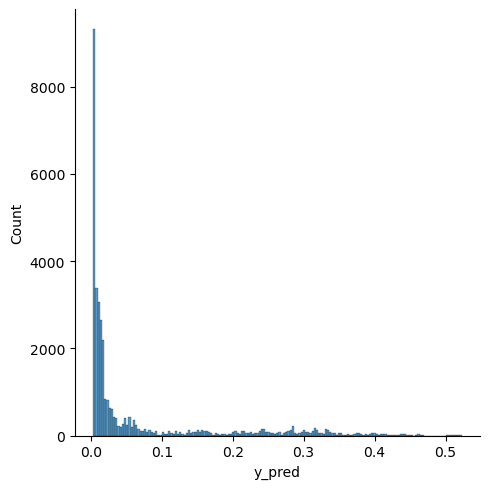

SBER


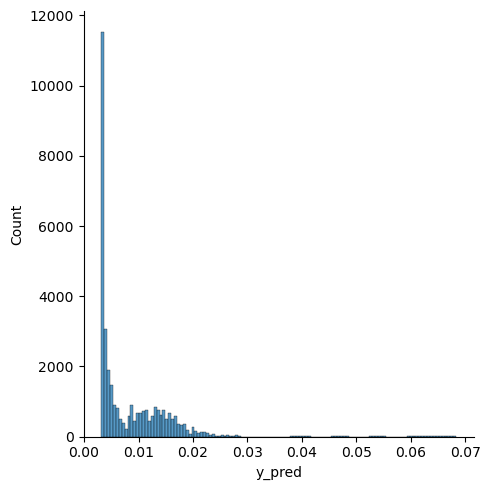

LKOH


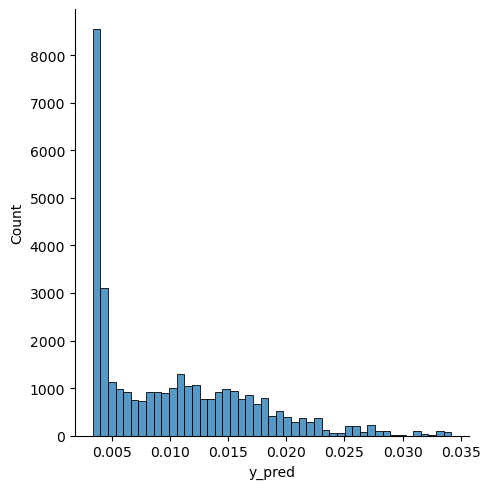

MGNT


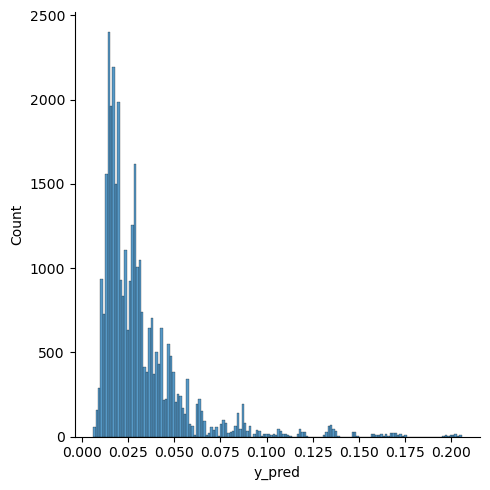

NVTK


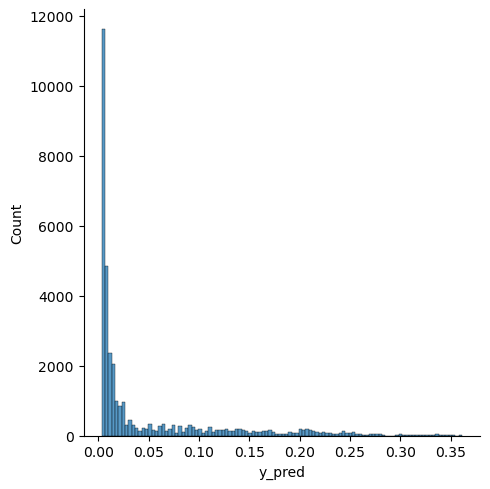

SNGS


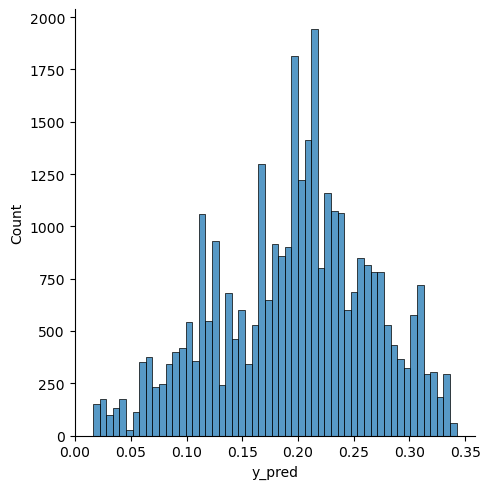

GMKN


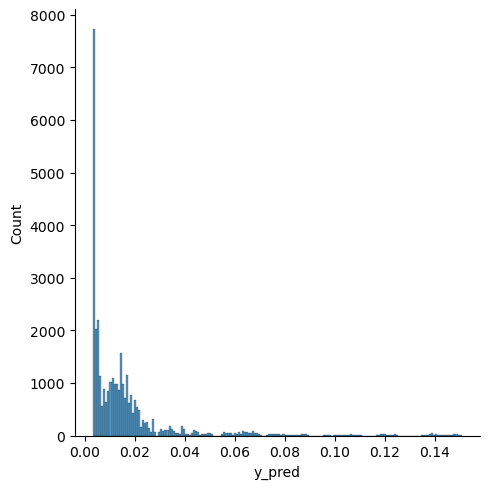

ROSN


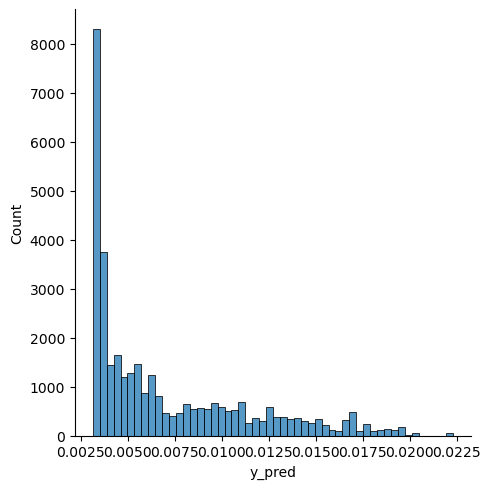

NLMK


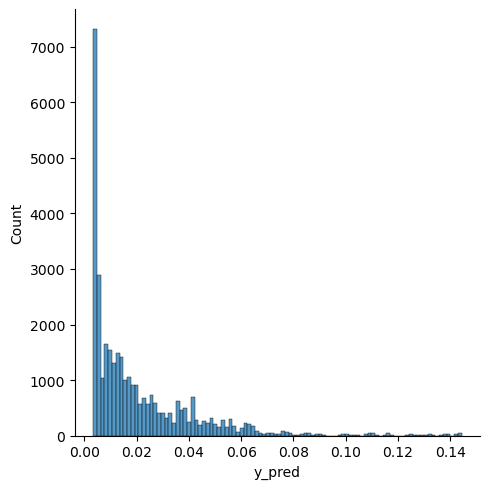

TATN


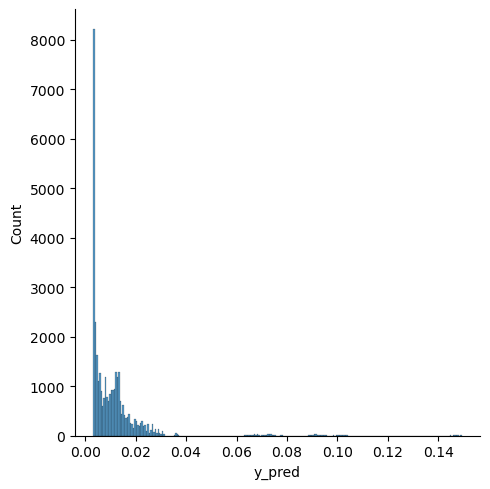

MTSS


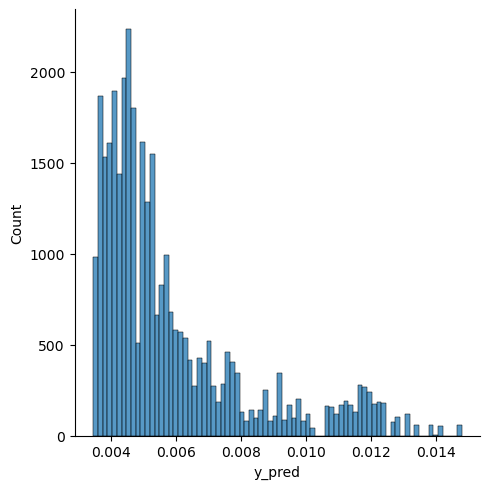

ALRS


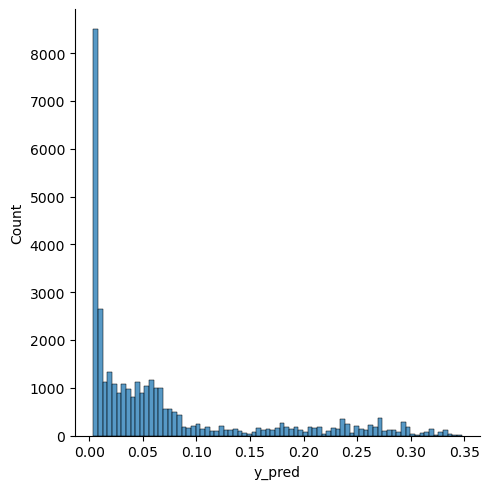

YDEX


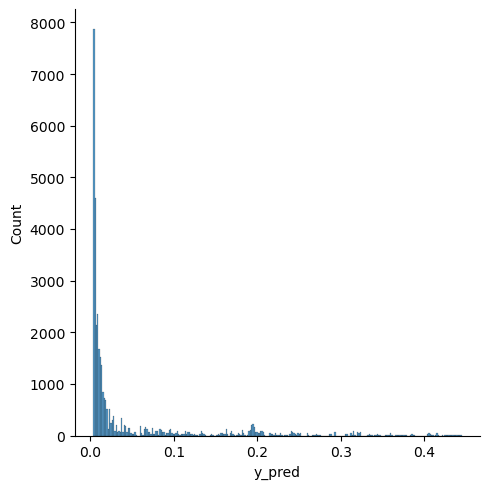

CHMF


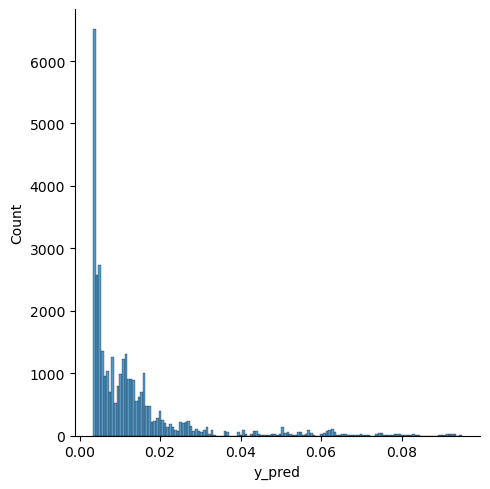

MAGN


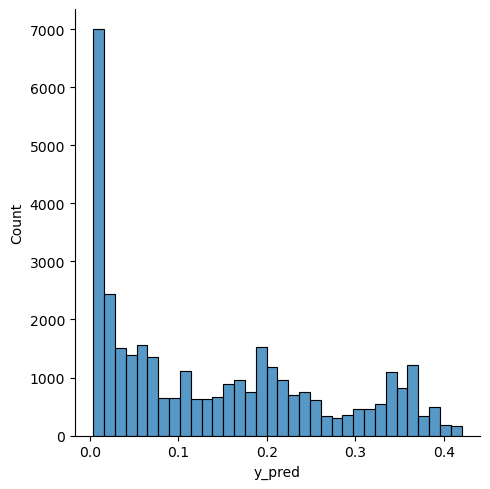

TCSG


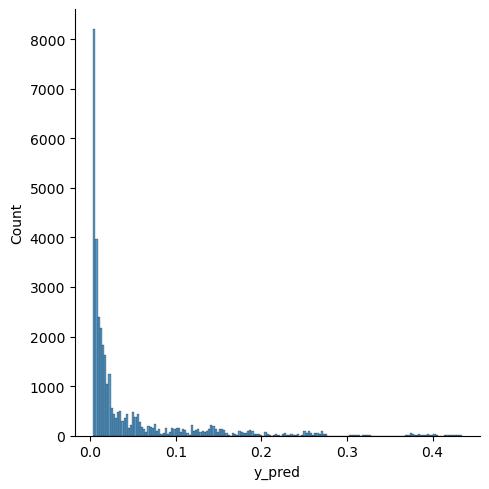

OZON


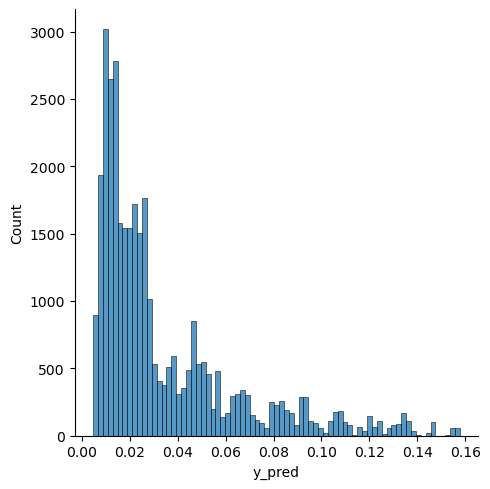

RUAL


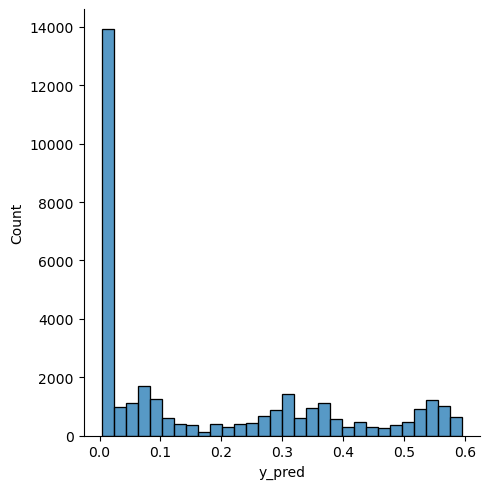

In [72]:
for ticker in df_1min['ticker'].unique():
    print(ticker)
    sns.displot(df_1min.loc[df_1min['ticker'] == ticker, 'y_pred'])
    plt.show()

In [99]:
mask = (df_1min['ticker'] == 'GAZP') & (df_1min['sample'] == 'test') & (df_1min['time'] > pd.Timestamp('2024-09-23')) #& (df_1min['time'] < pd.Timestamp('2024-09-24'))
mask.sum()

4866

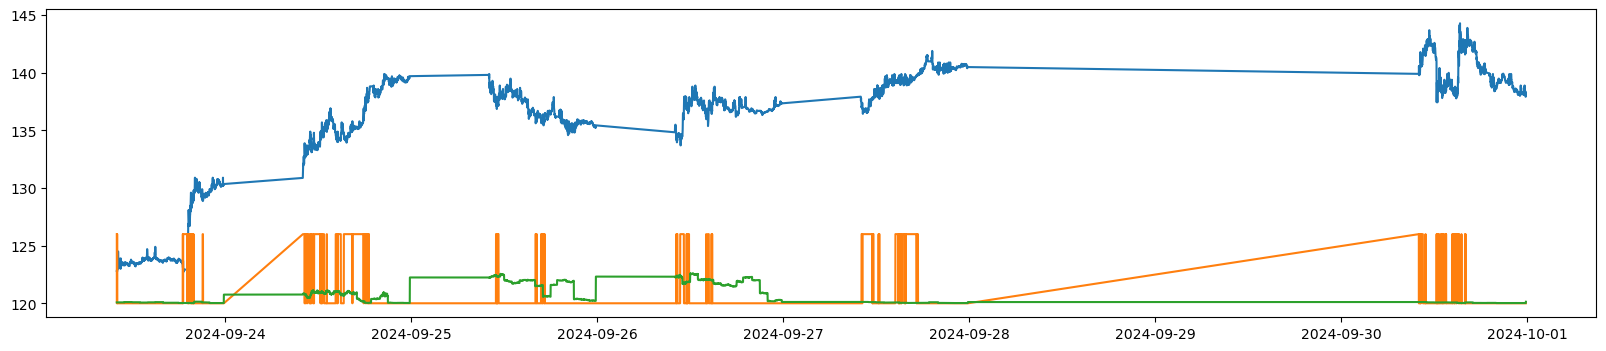

In [101]:

plt.figure(figsize=(20,4))
df_tmp = df_1min.loc[mask].copy()
df_tmp = df_tmp.set_index('time')

plt.plot(df_tmp['close'])
plt.plot(6*df_tmp['target']+120)
plt.plot(6*df_tmp['y_pred']+120)

# TMP

In [ ]:
import tensorflow as tf
tf.keras.backend.floatx()